## Classification Problem (MNIST)

notes: This is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “hello world” of Machine Learning: whenever people come up with a new classification algorithm they are curious to see how it will perform on MNIST, and anyone who learns Machine Learning tackles this dataset sooner or later.

#### Checklist of ML

1. Frame the problem and look at the big picture.
2. Get the data.
3. Explore the data to gain insights.
4. Prepare the data to better expose the underlying data patterns to Machine Learn‐
ing algorithms.
5. Explore many different models and shortlist the best ones.
6. Fine-tune your models and combine them into a great solution.
7. Present your solution.
8. Launch, monitor, and maintain your system.

In [75]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

##### getting the data

In [2]:
mnist = fetch_openml('mnist_784', version=1)

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y  = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)


# There are 70,000 images, and each image has 784 features. This is because each image
# is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0
# (white) to 255 (black).

(70000, 784)
(70000,)


5


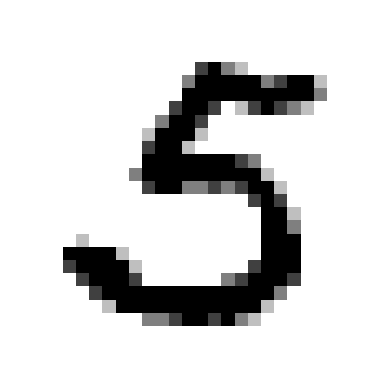

In [4]:
#checking out an image by selecting random rows

rand_val = np.random.randint(y.shape[0])
some_digit = X.loc[rand_val, :]

print(y[rand_val])

some_digit_image = np.array(some_digit).reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [5]:
# Most ML algorithms expect numbers, so let’s cast y to integer

y = y.astype(np.uint8)


##### Data preparation

In [6]:
# You should always create a test set and set it aside before inspecting the data

X_train, X_test, y_train, y_test = X[:
                                     60000], X[60000:], y[:60000], y[60000:]

# The training set is already shuffled for us, which is good because this guarantees that
# all cross-validation folds will be similar (you don’t want one fold to be missing some
# digits). Moreover, some learning algorithms are sensitive to the order of the training
# instances, and they perform poorly if they get many similar instances in a row. Shuf‐
# fling the dataset ensures that this won’t happen

#### Training a Binary Classifier

Start with creating a “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5. 


In [7]:
# getting the 5s, True for 5s and False for all other digits

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

A good place to start is with a Stochastic Gradi‐
ent Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier
has the advantage of being capable of handling very large datasets efficiently

In [8]:
sdg_clf = SGDClassifier(random_state=42)
sdg_clf.fit(X_train, y_train_5)



SGDClassifier(random_state=42)

[False]


c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


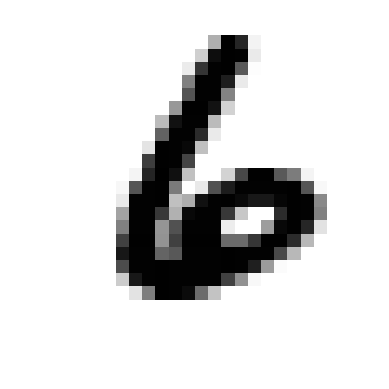

In [9]:
rand_val = np.random.randint(y.shape[0])
some_digit = X.loc[rand_val, :]

predict_val = sdg_clf.predict([some_digit])
print(predict_val)


some_digit_image = np.array(some_digit).reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

### Performance Measure

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we
will spend a large part of this chapter on this topic. There are many performance
measures available,

Using cross-validation

###### using our custom method 1

In [10]:
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sdg_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/ len(y_pred))
 
 
# The StratifiedKFold class performs stratified sampling (as explained in Chapter 2)
# to produce folds that contain a representative ratio of each class. At each iteration the
# code creates a clone of the classifier, trains that clone on the training folds, and makes
# predictions on the test fold. Then it counts the number of correct predictions and
# outputs the ratio of correct predictions.


0.95035
0.96035
0.9604


###### using scikit cross_val_score()

using cross_val_score() function to evaluate our SGDClassifier model,
using K-fold cross-validation with three folds. Remember that K-fold cross-validation
means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds.

In [11]:
cross_val_score(sdg_clf, X=X_train, y=y_train_5, cv=3, scoring="accuracy")


# Above 93% accuracy (ratio of correct predictions) on all cross-validation folds?
# This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very
# dumb classifier that just classifies every single image in the “not-5” class

array([0.95035, 0.96035, 0.9604 ])

###### another classifier (dumb)

In [12]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
(len(X), 1),

((70000, 1),)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# That’s right, it has over 90% accuracy! This is simply because only about 10% of the
# images are 5s, so if you always guess that an image is not a 5, you will be right about
# 90% of the time. Beats Nostradamus.
# This demonstrates why accuracy is generally not the preferred performance measure
# for classifiers, especially when you are dealing with skewed datasets (i.e., when some
# classes are much more frequent than others).

array([0.91125, 0.90855, 0.90915])

###### Confusion Matrix, method 2

In [14]:
y_train_pred = cross_val_predict(sdg_clf, X_train, y_train_5, cv=3)

In [15]:
confusion_matrix(y_train_5, y_train_pred)

# Each row in a confusion matrix represents an actual class, while each column repre‐
# sents a predicted class. The first row of this matrix considers non-5 images (the nega‐
# tive class): 53,057 of them were correctly classified as non-5s (they are called true
# negatives), while the remaining 1,522 were wrongly classified as 5s (false positives).
# The second row considers the images of 5s (the positive class): 1,325 were wrongly
# classified as non-5s (false negatives), while the remaining 4,096 were correctly classi‐
# fied as 5s (true positives). A perfect classifier would have only true positives and true
# negatives, so its confusion matrix would have nonzero values only on its main diago‐
# nal (top left to bottom right):

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

An interesting one to look at is the accuracy of the positive predictions; this is called the precision of the classifier:


precision = TP/(TP+FP)...   TP = number of true positive, FP = number of false positive

###### Precision and Recall, method 3

In [16]:
# Scikit-Learn provides several functions to compute classifier metrics, including preci‐
# sion and recall:

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred)

# Now the 5-detector does not look as shiny as it did when you looked at its accuracy.
# When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s

0.6511713705958311

It is often convenient to combine precision and recall into a single metric called the F1
score, in particular if you need a simple way to compare two classifiers. The F1 score is
the harmonic mean of precision and recall . Whereas the regular mean
treats all values equally, the harmonic mean gives much more weight to low values.
As a result, the classifier will only get a high F1 score if both recall and precision are high.

F1 = 2/(1/precision  + 1/racall)  =  2 * (precision*recall)/(precision + recall) = TP/(TP+ (FN+FP)/2)

In [18]:
f1_score(y_train_5, y_train_pred)

# Note that increasing precision reduces recall, and
# vice versa. This is called the precision/recall trade-off.

0.7325171197343847

In [19]:
# So to understand precision and recall here..... precision is the number of 5s that was correctly picked out of selected number of
# positives (both false and true positives.), like predicting four 5s out of six positive where one value is 6, hence the prdiction has 80% precision. SInce there
# are six 5s and it correctly predicted four of the 5s, then the recall is the correct predicion (four 5s) vrs the total 5s in the set... hence the recall is 67%.. This 
# is when the threshold is place at the second bar from the left. Different thresholds give different prec and rec, as shown below.
#  If you raise the threshold (move it to the arrow on the right), the false positive (the 6) becomes a true negative, thereby increasing the 
# precision (up to 100% in this case), but one true positive becomes a false negative, decreasing recall down to 50%. Conversely, lowering
# the threshold increases recall and reduces precision.



#            pr: 6/8=75%      pr: 4/5=80%   pr: 3/3=100% 
#            re: 6/6=100%     re: 4/6=67%   re: 3/6=50% 
# 8    7    3    9 |  5   2   5 | 5     6    | 5 5 5
# neg predictions                         pos predictions
# <-------------                          --------------->
# -------------------------------------------------------> score

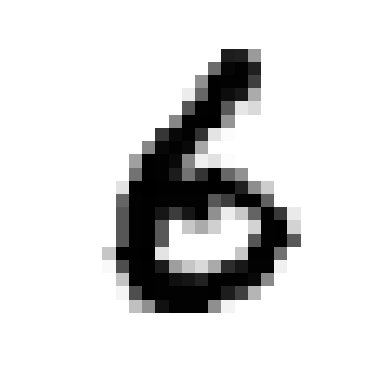

[-1729.19953537]
[False]
[False]


c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [20]:
rand_val = np.random.randint(y.shape[0])
some_digit = X.loc[rand_val, :]

some_digit_image = np.array(some_digit).reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

y_scores = sdg_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

In [21]:
# choosing the best threshold using cross_val_predict()

y_scores = cross_val_predict(sdg_clf, X_train, y_train_5, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


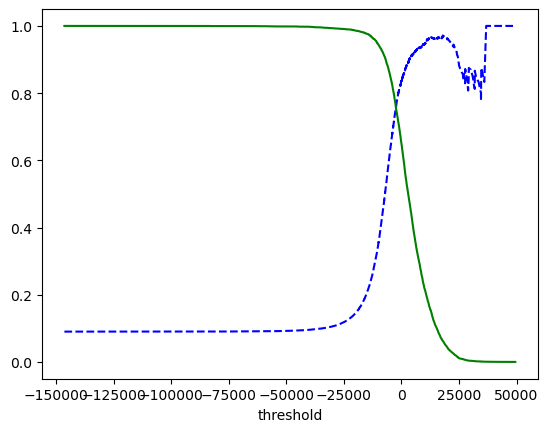

In [22]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel('threshold')


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


Text(0, 0.5, 'Precision')

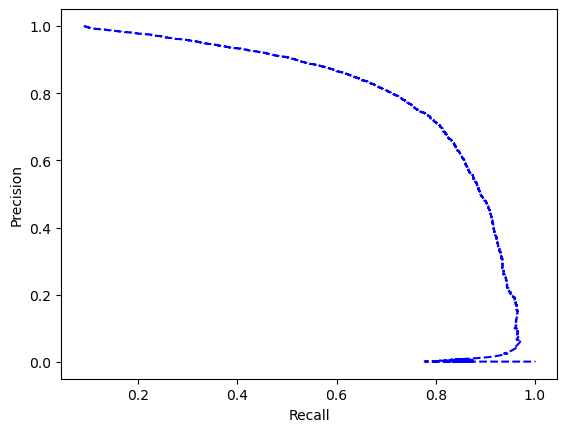

In [23]:
plt.plot(precisions, recalls, "b--",)
plt.xlabel('Recall')
plt.ylabel("Precision")

# You can see that precision really starts to fall sharply around 80% recall. You will
# probably want to select a precision/recall trade-off just before that drop—for exam‐
# ple, at around 60% recall. But of course, the choice depends on your project

In [24]:
# gettin high precision of 90%  -> that will fetch a threshold of about 8000

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5, y_train_pred_90))

print(recall_score(y_train_5, y_train_pred_90))

# Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a
# classifier with virtually any precision you want: just set a high enough threshold, and
# you’re done. But wait, not so fast. A high-precision classifier is not very useful if its
# recall is too low!


0.9000345901072293
0.4799852425751706


###### The ROC curve, method 4

The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate(TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity

In [25]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

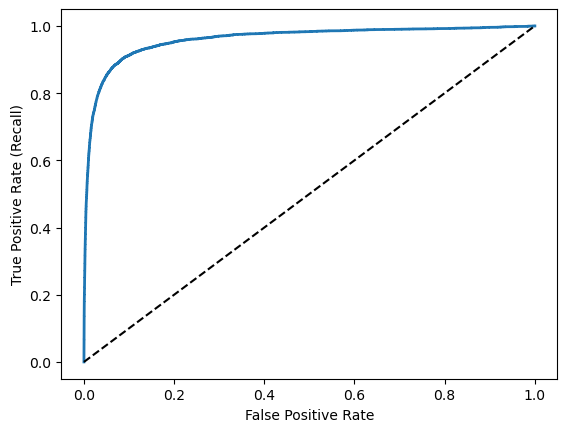

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate')


plot_roc_curve(fpr, tpr)
plt.show()

In [27]:
roc_auc_score(y_train_5, y_scores)

# Since the ROC curve is so similar to the precision/recall (PR)
# curve, you may wonder how to decide which one to use. As a rule
# of thumb, you should prefer the PR curve whenever the positive
# class is rare or when you care more about the false positives than
# the false negatives. Otherwise, use the ROC curve. For example,
# looking at the previous ROC curve (and the ROC AUC score), you
# may think that the classifier is really good. But this is mostly
# because there are few positives (5s) compared to the negatives
# (non-5s). In contrast, the PR curve makes it clear that the classifier
# has room for improvement (the curve could be closer to the topleft corner)

0.9604938554008616

##### Trying the Random Forest Classifier

Here we want to compare the ROC curve of the random forest classifier to that of the SGDClassifier

In [28]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

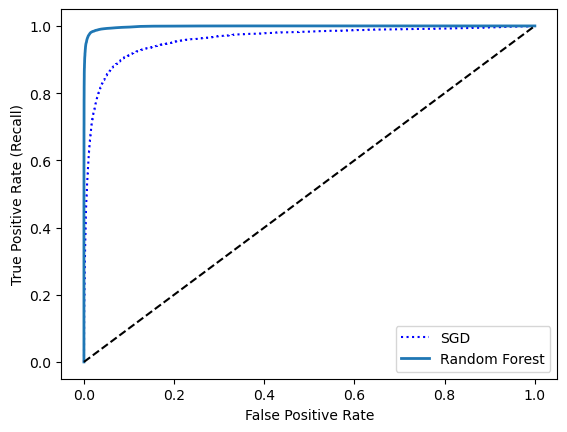

In [29]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

# Comparing ROC curves: the Random Forest classifier is superior to the SGD
# classifier because its ROC curve is much closer to the top-left corner, and it has a greater
# Area Under the Curve (AUC)

In [30]:
# its ROC AUC score is also significantly better

roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

You now know how to train binary classifiers, choose the appropriate metric for your
task, evaluate your classifiers using cross-validation, select the precision/recall trade-off that fits your needs, and use ROC curves and ROC AUC scores to compare various models. Now let’s try to detect more than just the 5s.

##### Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

In [31]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

In [32]:
svm_clf.predict([some_digit])

# This code trains the SVC on the training set using the original target
# classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes
# (y_train_5). Then it makes a prediction (a correct one in this case). Under the hood,
# Scikit-Learn actually used the OvO strategy - one-versus-one strategy: it trained 45 binary classifiers, got their
# decision scores for the image, and selected the class that won the most duels.

c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([6], dtype=uint8)

In [33]:
print(svm_clf.classes_)  # the classes from 0 to 9

# lets check the scores for the prediction
some_digit_scores = svm_clf.decision_function([some_digit])

# the highest score is likely the number being predicted
print('Scores: ', some_digit_scores)

print('The highest value: ', np.argmax(some_digit_scores))

print('The predicted number: ', svm_clf.classes_[np.argmax(some_digit_scores)])

[0 1 2 3 4 5 6 7 8 9]
Scores:  [[ 3.89903305  0.70870867  4.95048192  6.12659656  2.75606056  8.2965069
   9.31675064 -0.31554709  7.2936357   1.70754412]]
The highest value:  6
The predicted number:  6


c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the OneVsOneClassifier or OneVsRestClassifier classes

In [34]:
ovr_clf = OneVsRestClassifier(SVC())

ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warning

array([6], dtype=uint8)

##### Error Analysis

In [35]:
y_train_pred = cross_val_predict(sdg_clf, X_train, y_train, cv=3)


In [36]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]],
      dtype=int64)

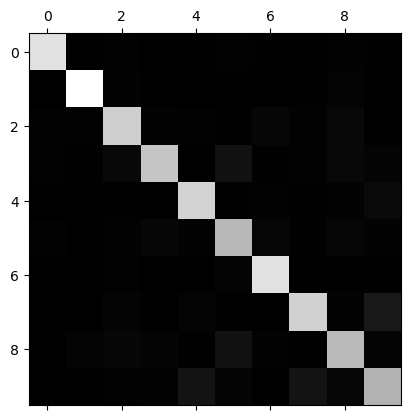

In [37]:
## ploting the matrix

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

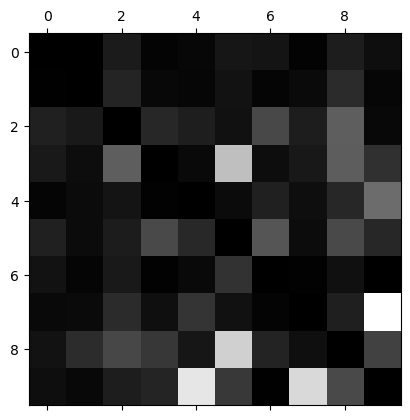

In [38]:
#  First, you need to divide each value in the confusion
# matrix by the number of images in the corresponding class so that you can compare
# error rates instead of absolute numbers of errors (which would make abundant
# classes look unfairly bad)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

# lets feel the diagonal with zeros to keep only the errors, and plot the result.

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [72]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


# def plot_digits(X, images_per_row=5):

#     for index, row in X.iterrows():
#         some_digit_image = np.array(row).reshape(28, 28)
#         plt.imshow(some_digit_image, cmap='binary')
#         plt.axis("off")
#         plt.show()



# plt.figure(figsize=(8, 8))
# plt.subplot(221)
# plot_digits(X_aa[:25], images_per_row=5)
# plt.subplot(222)
# plot_digits(X_ab[:25], images_per_row=5)
# plt.subplot(223)
# plot_digits(X_ba[:25], images_per_row=5)
# plt.subplot(224)
# plot_digits(X_bb[:25], images_per_row=5)
# plt.show()

#### Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases you
 may want your classifier to output multiple classes for each instance. Consider a face
recognition classifier: what should it do if it recognizes several people in the same
 picture? It should attach one tag per person it recognizes. Say the classifier has been
 trained to recognize three faces, Alice, Bob, and Charlie. Then when the classifier is
 shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes,
 Bob no, Charlie yes”). Such a classification system that outputs multiple binary tags is
 called a multilabel classification system.

We won’t go into face recognition just yet, but let’s look at a simpler example, just for illustration purposes:

In [78]:
# first we create two targets,
# one that indicates a wherether a digit is large (7, 8, or 9) or not
y_train_large = (y_train >= 7)

# and another that incates whether or not it is odd. 
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)


KNeighborsClassifier()

c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


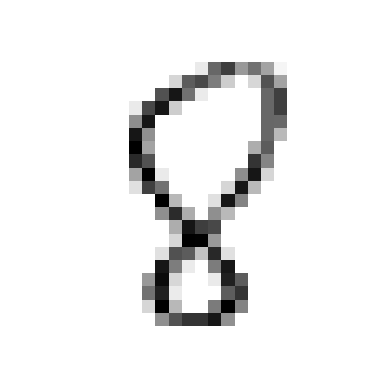

c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[ True, False]])

In [85]:
rand_val = np.random.randint(y.shape[0])
some_digit = X.loc[rand_val, :]

predict_val = sdg_clf.predict([some_digit])

some_digit_image = np.array(some_digit).reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

knn_clf.predict([some_digit])

In [87]:
## We can consider using F1 score to evaluate this classifier.. 
# selecting the right model depends on the project

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# This assumes that all labels are equally important, however, which may not be the
#  case. In particular, if you have many more pictures of Alice than of Bob or Charlie,
#  you may want to give more weight to the classifier’s score on pictures of Alice. One
#  simple option is to give each label a weight equal to its support (i.e., the number of
# instances with that target label). To do this, simply set average="weighted" in the
#  preceding code.

0.9764102655606048

##### Multioutput Classification

 The last type of classification task we are going to discuss here is called multioutput
multiclass classification (or simply multioutput classification). It is simply a generaliza
tion of multilabel classification where each label can be multiclass (i.e., it can have
 more than two possible values).

 To illustrate this, let’s build a system that removes noise from images. It will take as
 input a noisy digit image, and it will (hopefully) output a clean digit image, repre
sented as an array of pixel intensities, just like the MNIST images. Notice that the
 classifier’s output is multilabel (one label per pixel) and each label can have multiple
 values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput
 classification system

In [92]:
noise = np.random.randint(0, 100, (len(X_train), 784))  # generating random transformations for train
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))  # generating randome transformations for test
X_test_mod = X_test + noise

y_train_mod = y_train
y_test_mod = y_test

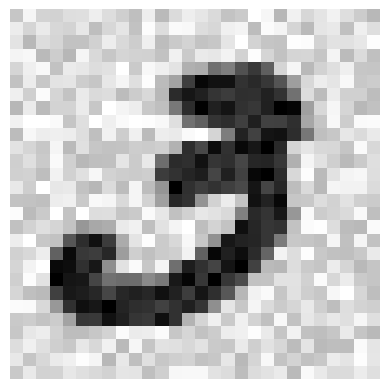

In [103]:
# lets check the images with the noise

rand_val = np.random.randint(X_train_mod.shape[0])
some_digit = X_train_mod.loc[rand_val, :]

some_digit_image = np.array(some_digit).reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()


In [117]:
# now lets train a classifier to identify the image


def plot_digits(pred_digit):

    some_digit_image = np.array(pred_digit).reshape(28, 28)
    plt.imshow(some_digit_image, cmap='binary')
    plt.axis("off")
    plt.show()


knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([some_digit])
# plot_digits(clean_digit)

print(clean_digit)

[3]


c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
